# QAOA on MaxCut

We implement QAOA to approximately solve the MaxCut problem for a given graph.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The graph in question is given below:

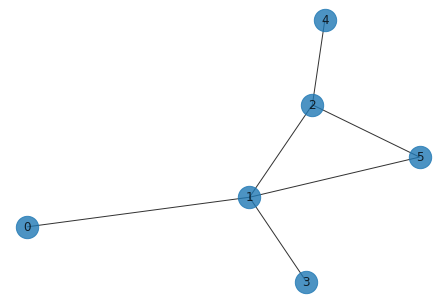

In [2]:
G = nx.Graph()
G.add_nodes_from(np.arange(0, 5))
G.add_edges_from([(0, 1), (1, 3), (1, 2), (1, 5), (5, 2), (2, 4)]) 

nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

#### a) Find the exact max-cut for this graph

The exact max-cut for this graph is 5. The three solutions of two disjoint sets with 5 cuts are
- $\{0,3,4,5\},\{1,2\}$
- $\{0,2,3\},\{1,4,5\}$
- $\{0,2,3,5\},\{1,4\}$

#### b) Goemans-Williamson algorithm to find approximate solution

The optimisation problem of MaxCut can be formulated as a quadratic program with binary variables. The classical method using semidefinite programming for solving the MaxCut problem developed by Goemans and Williamson provides an approximate solution with a performance ratio 0.87856 <$\alpha$< 0.87857. 

The following code from [this video](https://www.youtube.com/watch?v=aFVnWq3RHYU) this video was implemented to solve the MaxCut problem using the Goemans-Williamson algorithm.

In [3]:
import cvxpy as cp
from scipy import linalg

In [4]:
# edges of given graph
edges = [(0,1),
        (1,2),
        (1,3),
        (1,5),
        (2,4),
        (2,5)]

# creates 6x6 symmetric matrix optimisation variable
X = cp.Variable((6,6), symmetric=True)

# creates constraints on X (positive semidefinite & symmetric)
constraints = [X>>0]
constraints += [
    X[i,i] == 1 for i in range (6)
]

# algorithm: 
objective = sum(0.5*(1-X[i,j]) for (i,j) in edges)

In [5]:
prob = cp.Problem(cp.Maximize(objective), constraints)
prob.solve()

5.250000797097679

#### c) QAOA with depth $p=1$

For a given graph, we have that the objective function is given by
    \begin{align*}
        C &= \sum{\langle jk\rangle} C_{\langle jk\rangle} \\
        &= \sum_{\langle jk\rangle} \frac{1}{2} \left(1-\sigma^z_j\sigma^z_k\right)
    \end{align*}
    
for each edge $\langle jk\rangle$. Write $Z_i = \sigma^z_i$. The objective function for this particular graph is

$$C = 3-\frac{1}{2}\left[Z_0Z_1+Z_1Z_2+Z_1Z_3+Z_1Z_5+Z_2Z_4+Z_2Z_5\right]$$

Define the unitary $U(C,\gamma)$ as 
    \begin{align*}
        U(C,\gamma) &= e^{-i\gamma C} \\
        &= \prod_{\langle jk\rangle} e^{-i\gamma C_{\langle jk\rangle}}.
    \end{align*}
    
The unitary $U(C,\gamma)$ for this particular graph is

$$U(C,\gamma) = e^{-3i\gamma}e^{\frac{i\gamma}{2}Z_0Z_1}e^{\frac{i\gamma}{2}Z_1Z_2}e^{\frac{i\gamma}{2}Z_1Z_3}e^{\frac{i\gamma}{2}Z_1Z_5}e^{\frac{i\gamma}{2}Z_2Z_4}e^{\frac{i\gamma}{2}Z_2Z_5}$$

Next, define the unitary $U(B,\beta)$ as

$$B = \sum^n_{j=0} \sigma^x_j$$

for each node $0,\dots, n$. Write $\sigma^x_j=X_j$. Then $U(B,\beta)$ for the graph is

$$B = X_0+X_1+X_2+X_3+X_4+X_5$$

The next section implements the QAOA circuit. First, we import the necessary packages

In [6]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute, assemble
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
from qiskit.visualization import plot_state_city

We next define a function that creates the quantum circuit from a given graph and parameters $\beta$ and $\gamma$.

In [102]:
def make_circuit(graph, angles):
    """
    Creates quantum circuit for the of wavefunction after applying 
    the unitaries U(C, \gamma) and U(B, \beta).
    
    INPUT:
    - ```G```: networkx graph of problem graph
    - ```angles```: array double list of unitary parameters
    OUTPUT: QuantumCircuit of problem graph after applying unitaries
    """
    
    nqubits = len(graph.nodes())
    p = len(angles)//2  # number of alternating unitaries
    
    beta = angles[:p]
    gamma = angles[p:]
    
    # generates initial state
    qc = QuantumCircuit(nqubits)
    for i in range(0, nqubits):
        qc.h(i)
    
    for i in range(0,p):
    
        # generates problem unitary U(C, \gamma)
        for pair in list(graph.edges()):  # pairs of nodes
            qc.rzz(2 * gamma[i], pair[0], pair[1])
            qc.barrier()

        # generates mixing unitary U(B, \beta)
        for j in range(0, nqubits):
            qc.rx(2 * beta[i], j)

    # generates circuit
    #qc.measure_all()

    return qc

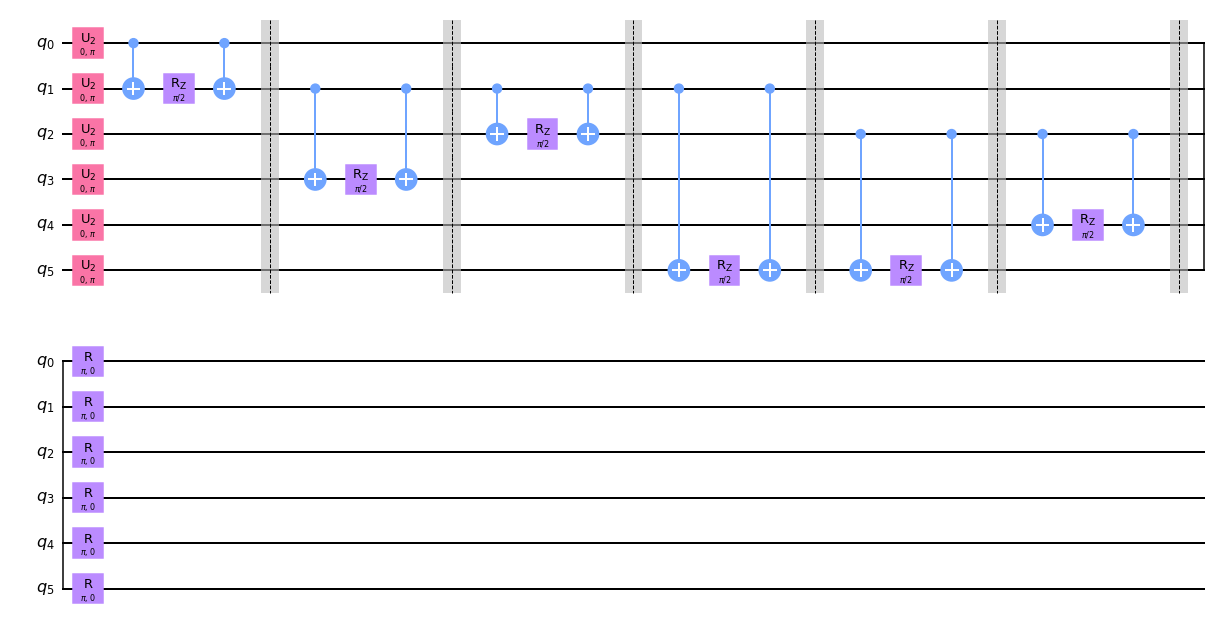

In [103]:
# circuit for example circuit where beta=pi/2 and gamma=pi/4
qc = make_circuit(G, [np.pi/2,np.pi/4])
qc.decompose().draw(output='mpl')

The next function calculates the cost value for a given cut. We also define a function that creates a histogram of all possible cuts and provides a visualisation of the likelihood for such a cut to occur.

In [104]:
def maxcut_obj(bitstring, graph):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    INPUT:
    - ```graph``` - networkx graph of problem graph
    - ```bitstring``` - int array solution bitstring
    OUTPUT: float - cost of graph
    """
    
    value = 0
    for i, j in graph.edges():
        if bitstring[i] != bitstring[j]:
            value -= 1
            
    return value

def maxcut_obj_weighted(graph, bitstring):
    """
    Computes the maxcut cost function of a general weighted graph
    and cut represented by some bitstring.
    
    INPUT:
    - ```graph```: networkx graph of problem graph
    - ```bitstring```: string solution bitstring
    OUTPUT: float - cost of graph
    """
    # Get the weight matrix of the graph
    weight_matrix = nx.adjacency_matrix(graph).toarray()
    size = weight_matrix.shape[0]
    value = 0.

    for (u,v) in graph.edges():
        if bitstring[u]!=bitstring[v]:
            value += weight_matrix[u,v]
    
    return value

def compute_expectation(counts, graph):
    """
    Computes expectation value based on measurement results
    
    INPUT:
    - ```counts''': dictionary with key as the bitstring, and val as the count
    - ```graph''': networkx graph
        
    OUTPUT: float - average expectation value for graph
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def get_expectation(graph, shots=512):
    """
    Runs parametrised circuit and returns expectation 
    Creates quantum circuit for the of wavefunction after applying 
    the unitaries U(C, \gamma) and U(B, \beta).
    
    INPUT:
    - ```graph```: networkx graph of problem graph
    - ```shots```: array double list of unitary parameters
    OUTPUT: expectation value from executing circuit
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = make_circuit(graph, theta)
        qc.measure_all()
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, graph)
    
    return execute_circ

def measure(qc):
    
    backend = Aer.get_backend('aer_simulator')
    qc.save_statevector()
    qobj = assemble(qc)
    final_state = backend.run(qobj).result().get_statevector()
    
    return final_state

In [105]:
from typing import List
import plotly.graph_objects as go

def plot_maxcut_histogram(graph):
    """
    Plots a bar diagram with the values for all possible cuts of a given graph.
    INPUT:
    - ```graph``` -  networkx graph of problem graph
    """
    num_vars = graph.number_of_nodes()
    
    # Create list of bitstrings and corresponding cut values
    bitstrings = ['{:b}'.format(i).rjust(num_vars, '0')[::-1] for i in range(2**num_vars)]
    values = [maxcut_obj_weighted(graph = graph, bitstring = [int(x) for x in bitstring]) for bitstring in bitstrings]
    
    # Sort both lists by largest cut value
    values, bitstrings = zip(*sorted(zip(values, bitstrings)))
    
    # Plot bar diagram
    bar_plot = go.Bar(x = bitstrings, y = values, marker=dict(color=values, colorscale = 'plasma', colorbar=dict(title='Cut Value')))
    fig = go.Figure(data=bar_plot, layout = dict(xaxis=dict(type = 'category'), width = 1500, height = 600))
    fig.show()

In [106]:
plot_maxcut_histogram(G)

Since $p$ is small and there are only two parameters, $\beta$ and $\gamma$, a simple grid search can be performed 

https://qiskit.org/textbook/ch-applications/qaoa.html#3.-Approximate-optimization-algorithms-

In [107]:
from scipy.optimize import minimize

expectation = get_expectation(G)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
print(f"The angles that maximises the expectation value of the cost is given by: \n\
\u03B2 = {res.x[0]}, and \n\
\u03B3 = {res.x[1]}.")


The angles that maximises the expectation value of the cost is given by: 
β = 1.2486988411424915, and 
γ = 0.3339342876366491.


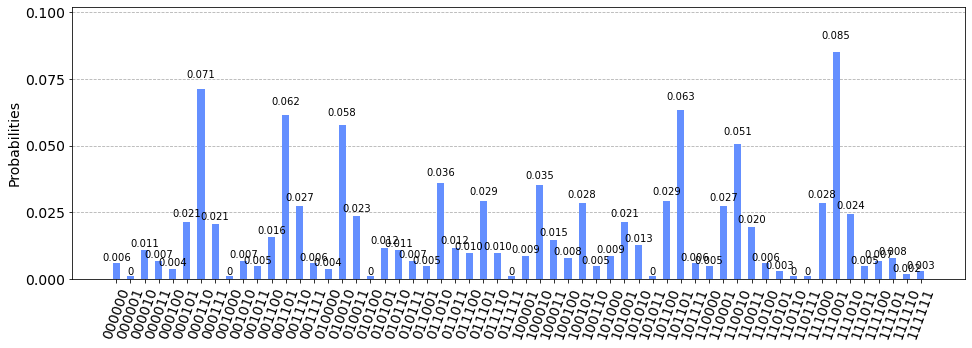

In [110]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = make_circuit(G, res.x)
qc_res.measure_all()

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts, figsize = (16,5))

In [111]:
qc_opt = make_circuit(G, res.x)
sv_opt = measure(qc_opt)

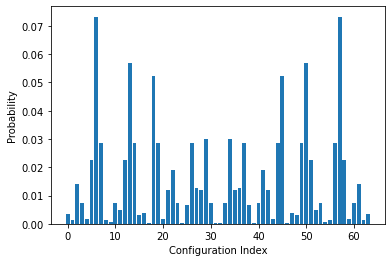

In [112]:
prob_vec_opt = np.abs(sv_opt)**2
plt.bar(np.arange(64), prob_vec_opt)
plt.ylabel("Probability")
plt.xlabel("Configuration Index")
plt.show()

In [114]:
def tensor_power(vect, power):
    """
    Raises a vector to the n-th tensor product.
    
    INPUT:
    ```vect``` - array vector
    ```power``` - int power 
    OUTPUT: array vector
    """
    
    vector = vect
    for i in range(power):
        vector = np.kron(vector, vect)
    
    return vector

def cost_function_matrix(graph):
    """
    Returns the matrix of the cost function of a 
    problem graph. Since the computational 
    
    INPUT: 
    ```graph```- networkx graph
    OUPUT: cost function matrix as np array
    """
    edges = list(graph.edges)
    n = len(graph.nodes())
    
    identity = np.array([[1, 0], [0, 1]])
    pauli_z = np.array([[1, 0], [0, -1]])
    
    full_id = np.identity(2**n)
    cost = np.zeros((2**n, 2**n))
    
    for (u,v) in edges:
        summands = [identity]*n
        summands[u] = pauli_z
        summands[v] = pauli_z
        
        initial = summands[0]
        
        for matrix in summands[1:]:
            initial = np.kron(initial, matrix)
            
        cost += initial
    
    return (len(edges)*full_id-cost) //2

In [117]:
cost_matrix = np.diag(cost_function_matrix(G))

Now we find the variance of the cost function, $\sigma^2=\langle C^2\rangle-\langle C\rangle^2$ at the statevector of the optimal solution for $p$=1.

In [118]:
print("Cost variance: ", np.sum(cost_matrix**2 * sv_opt) - np.sum(cost_matrix * sv_opt)**2)

Cost variance:  (275.36837601305825+189.28134414753143j)


#### d) QAOA with depth $p=2$
We find the optimal angles for depth $p=2$ of the max-cut problem for the graph. We again do this by finding the average cost taken over many simulations.

In [55]:
expectation = get_expectation(G)

res = minimize(expectation, 
                      [1.0, 1.0, 1.0, 1.0], 
                      method='COBYLA')
print(f"The angles that maximises the expectation value of the cost is given by: \n\
\u03B2 = {res.x[0], res.x[1]}, and \n\
\u03B3 = {res.x[2], res.x[3]}.")

The angles that maximises the expectation value of the cost is given by: 
β = (1.4238477436512578, 1.9547213327899995), and 
γ = (1.9201826397735728, 0.8503171993729487).


#### e) QAOA with depth $p=3$ and $p=4$
We find the optimal angles for depth $p=3$ of the max-cut problem for the graph. We again do this by finding the average cost taken over many simulations.

In [56]:
# p = 3

expectation = get_expectation(G)

res = minimize(expectation, 
                      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 
                      method='COBYLA')
print(f"The angles that maximises the expectation value of the cost is given by: \n\
\u03B2 = {res.x[0], res.x[1], res.x[2]}, and \n\
\u03B3 = {res.x[3], res.x[4], res.x[5]}.")

The angles that maximises the expectation value of the cost is given by: 
β = (0.8539877071588928, 1.1963066593250553, 1.1205081687892262), and 
γ = (0.9730797805045815, 0.9968661173796155, 0.9399025833770703).


In [57]:
# p = 4

expectation = get_expectation(G)

res = minimize(expectation, 
                      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 
                      method='COBYLA')
print(f"The angles that maximises the expectation value of the cost is given by: \n\
\u03B2 = {res.x[0], res.x[1], res.x[2], res.x[3]}, and \n\
\u03B3 = {res.x[4], res.x[5], res.x[6], res.x[7]}.")

The angles that maximises the expectation value of the cost is given by: 
β = (1.2171700691764262, 1.4031889531847734, 1.8285284988102155, 1.3147870954861376), and 
γ = (1.3141626996529918, 0.49901687323132154, 0.7673176123971338, 1.0527210191572551).


---

### Analytic expression for $\langle\gamma,\beta|C_{uv}|\gamma,\beta\rangle$ when $p=1$

We plot a contour plot of the expression 

$$\langle\gamma,\beta|C_{uv}|\gamma,\beta\rangle = \frac{1}{2}+\frac{1}{4}(\sin4\beta\sin\gamma)(\cos^{d_u}\gamma+\cos^{d_v}\gamma)-\frac{1}{4}(\sin^22\beta\cos^{d_u+d_v-2\lambda_{uv}}\gamma)(1-\cos^{\lambda_{uv}}2\gamma)$$

where $d_u=deg(u)-1, d_v=deg(v)-1$ and $\lambda_{uv}$ is the number of triangles in the graph containing an edge $\langle uv\rangle$. We calculate the cost function for a graph analytically below:

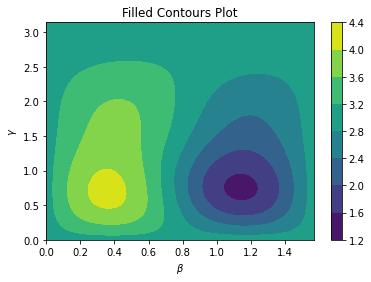

In [26]:
def analytic_cost_function(x, y, d, e, f):
    return 0.5+0.25*(np.sin(4*x)*np.sin(y))*(np.cos(y)**d + np.cos(y)**e)- \
           0.25*(np.sin(2*x)**2)*(np.cos(y)**(d+e-2*f))*(1-np.cos(2*y)**f)


adj_matrix = nx.to_numpy_array(G)
betalist = np.linspace(0, np.pi/2, 100)
gammalist = np.linspace(0, np.pi, 100)
X, Y = np.meshgrid(betalist, gammalist)
Z = 0

for (u,v) in G.edges():
    du = G.degree[u]-1
    dv = G.degree[v]-1
    lambda_uv = np.dot(adj_matrix[u], adj_matrix[v]) # number of triangles by 
                                                     # computing the dot product 
                                                     # of adjacency matrix columns
    
    Z += analytic_cost_function(X,Y,du,dv,lambda_uv)
    
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\gamma$')
plt.show()

#### Checking cost function

Code was used from https://qiskit.org/documentation/stable/0.24/locale/de_DE/tutorials/optimization/6_examples_max_cut_and_tsp.html
to check